# cat_dog_classifier

In [1]:
%tensorboard

UsageError: Line magic function `%tensorboard` not found.


In [2]:
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
import pathlib
dataset_url = "https://datasets-349058029.s3.us-west-2.amazonaws.com/cat_dog_classifier/cat_dog.zip"
data_dir = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir.replace('.zip', ''))
print(f"{len(list(data_dir.glob('*/*.jpg')))} images in dataset")

25000 images in dataset


In [4]:
batch_size = 64
img_size = 224

ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  image_size=(img_size, img_size),
  batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [5]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.1),
])

data_augmentation_fn = lambda x, y: (data_augmentation(x, training=True), y)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_split = 0.8
val_split = 0.1
test_split = 0.1

train_size = int(train_split * len(ds))
val_size = int(val_split * len(ds))

train_ds = ds.take(train_size).map(data_augmentation_fn, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE) 
val_ds = ds.skip(train_size).take(val_size).prefetch(buffer_size=AUTOTUNE) 
test_ds = ds.skip(train_size).skip(val_size).prefetch(buffer_size=AUTOTUNE) 

In [7]:
# model_name = '00'

# model = tf.keras.Sequential([
#   layers.InputLayer(input_shape=(img_size, img_size, 3)),
#   # layers.Resizing(img_size, img_size),
#   layers.Rescaling(1./127.5, offset=-1),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(2, activation='softmax')
# ])

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])



In [8]:
model_name = '1'

feature_extractor = tf.keras.applications.MobileNetV2(input_shape=(img_size, img_size, 3),
                                               include_top=False,
                                               weights='imagenet')
feature_extractor.trainable = False

model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(img_size, img_size, 3)),
        layers.Rescaling(1./127.5, offset=-1),
        feature_extractor,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(10, activation = 'relu'),
        tf.keras.layers.Dense(2, activation = None)])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 2,270,816
Trainable params: 12,832
Non-t

In [9]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=f'logs/{model_name}',
    histogram_freq=1)

In [10]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'models/{model_name}.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [11]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  # callbacks=[tensorboard_callback, model_checkpoint_callback]
  callbacks=[model_checkpoint_callback]
)

Epoch 1/15
312/312 [==============================] - 50s 148ms/step - loss: 0.1914 - accuracy: 0.9252 - val_loss: 0.0524 - val_accuracy: 0.9816
Epoch 2/15
312/312 [==============================] - 46s 145ms/step - loss: 0.1510 - accuracy: 0.9397 - val_loss: 0.0523 - val_accuracy: 0.9828
Epoch 3/15
312/312 [==============================] - 46s 145ms/step - loss: 0.1368 - accuracy: 0.9464 - val_loss: 0.0461 - val_accuracy: 0.9828
Epoch 4/15
312/312 [==============================] - 47s 147ms/step - loss: 0.1383 - accuracy: 0.9449 - val_loss: 0.0421 - val_accuracy: 0.9804
Epoch 5/15
312/312 [==============================] - 47s 148ms/step - loss: 0.1339 - accuracy: 0.9477 - val_loss: 0.0398 - val_accuracy: 0.9852
Epoch 6/15
312/312 [==============================] - 47s 147ms/step - loss: 0.1292 - accuracy: 0.9492 - val_loss: 0.0430 - val_accuracy: 0.9832
Epoch 7/15
312/312 [==============================] - 47s 148ms/step - loss: 0.1235 - accuracy: 0.9491 - val_loss: 0.0388 - val_ac

In [12]:
model = tf.keras.models.load_model(f'models/{model_name}.h5')
model.evaluate(test_ds)

40/40 [==============================] - 10s 95ms/step - loss: 0.0452 - accuracy: 0.9854


[0.04517164081335068, 0.9854100942611694]

[[-0.73604393 -8.949052  ]]
['Cat', 'Dog']
Cat -0.73604393


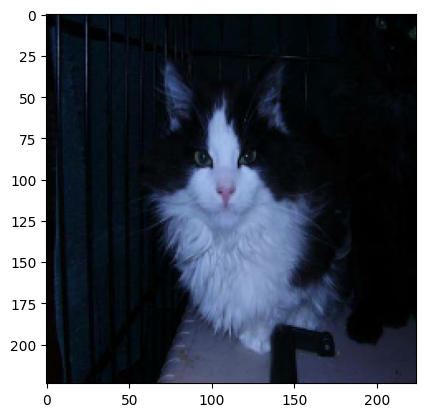

In [13]:
tensor = list(ds.take(1))[0][0][0]
pred = model.predict(tf.expand_dims(tensor, 0))
print(pred)
print(ds.class_names)
print(ds.class_names[pred.argmax()], pred.max())
im = tf.keras.utils.img_to_array(tensor, dtype=int)
plt.imshow(im)
plt.show()


In [14]:
!tensorflowjs_converter --input_format=keras --output_format=tfjs_graph_model './models/{model_name}.h5' ./tfjs_model

2022-03-24 01:48:18.845090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 01:48:18.849563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 01:48:18.849755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 01:48:18.850088: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [ ]:
# tfjs.converters.save_keras_model(model, './test_tfjs_model')